In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays # Para analise de feriados
import warnings
import time

# Configuracoes basicas
warnings.filterwarnings('ignore') # Suprime avisos comuns do pandas/seaborn
pd.set_option('display.max_columns', 50) # Mostrar mais colunas
sns.set_style('whitegrid') # Estilo dos graficos seaborn
plt.rcParams['figure.figsize'] = (12, 6) # Tamanho padrao das figuras matplotlib

print("Bibliotecas importadas e configuracoes basicas aplicadas.")

Bibliotecas importadas e configuracoes basicas aplicadas.


In [11]:
print("Carregando arquivos CSV...")

# Caminhos para os arquivos (ajuste se necessario)
path_product = './data/product.csv'
path_address = './data/rideaddress_v1.csv' # Usaremos apenas para referencia inicial, se necessario
path_ride_v2 = './data/ride_v2.csv'
path_estimative = './data/rideestimative_v3.csv'
# <<< IMPORTANTE: Confirme o nome exato do arquivo gerado pelo script ORS >>>
path_ors_results = './data/ors_local_coords_only_results.csv' # Ou o nome que voce salvou

try:
    # Carrega com separador e tratamento de encoding
    df_prod = pd.read_csv(path_product, sep=';', encoding='utf-8')
except UnicodeDecodeError:
    print("WARN: Falha UTF-8 em product.csv, tentando latin-1...")
    df_prod = pd.read_csv(path_product, sep=';', encoding='latin-1')
except FileNotFoundError:
    print(f"ERRO: Arquivo nao encontrado: {path_product}")
    df_prod = pd.DataFrame() # Cria df vazio para evitar erros posteriores

# try:
#     df_addr = pd.read_csv(path_address, sep=';', encoding='utf-8', low_memory=False)
# except UnicodeDecodeError:
#     print("WARN: Falha UTF-8 em rideaddress_v1.csv, tentando latin-1...")
#     df_addr = pd.read_csv(path_address, sep=';', encoding='latin-1', low_memory=False)
# except FileNotFoundError:
#     print(f"ERRO: Arquivo nao encontrado: {path_address}")
#     df_addr = pd.DataFrame()

try:
    df_rides = pd.read_csv(path_ride_v2, sep=';', encoding='utf-8', low_memory=False)
except UnicodeDecodeError:
    print("WARN: Falha UTF-8 em ride_v2.csv, tentando latin-1...")
    df_rides = pd.read_csv(path_ride_v2, sep=';', encoding='latin-1', low_memory=False)
except FileNotFoundError:
    print(f"ERRO: Arquivo nao encontrado: {path_ride_v2}")
    df_rides = pd.DataFrame()

try:
    df_estim = pd.read_csv(path_estimative, sep=';', encoding='utf-8', low_memory=False)
except UnicodeDecodeError:
    print("WARN: Falha UTF-8 em rideestimative_v3.csv, tentando latin-1...")
    df_estim = pd.read_csv(path_estimative, sep=';', encoding='latin-1', low_memory=False)
except FileNotFoundError:
    print(f"ERRO: Arquivo nao encontrado: {path_estimative}")
    df_estim = pd.DataFrame()

try:
    # Assumindo que o script ORS salvou com ; como separador
    df_ors = pd.read_csv(path_ors_results, sep=';', encoding='utf-8')
except UnicodeDecodeError:
    print(f"WARN: Falha UTF-8 em {path_ors_results}, tentando latin-1...")
    df_ors = pd.read_csv(path_ors_results, sep=';', encoding='latin-1')
except FileNotFoundError:
    print(f"ERRO: Arquivo nao encontrado: {path_ors_results}. Execute o script 'calcular_rotas_ors.py' primeiro.")
    df_ors = pd.DataFrame()
except Exception as e:
     print(f"ERRO ao carregar {path_ors_results}. Verifique o separador (sep=';') ou o arquivo. Erro: {e}")
     df_ors = pd.DataFrame()


# Verifica se os dataframes principais foram carregados
if df_rides.empty or df_estim.empty or df_ors.empty:
    print("\n!!! ERRO CRITICO: Nao foi possivel carregar um ou mais dos arquivos CSV principais (rides, estim, ors_results). Verifique os caminhos e erros acima. !!!")
else:
    print("\nCSVs carregados. Primeiras linhas:")
    print("\n--- df_rides (ride_v2) ---")
    print(df_rides.head(2))
    print(f"\nShape: {df_rides.shape}")
    print("\n--- df_estim (rideestimative_v3) ---")
    print(df_estim.head(2))
    print(f"\nShape: {df_estim.shape}")
    print("\n--- df_ors (resultados ORS local) ---")
    print(df_ors.head(2))
    print(f"\nShape: {df_ors.shape}")
    if not df_prod.empty:
        print("\n--- df_prod (product) ---")
        print(df_prod.head(2))
        print(f"\nShape: {df_prod.shape}")

Carregando arquivos CSV...

CSVs carregados. Primeiras linhas:

--- df_rides (ride_v2) ---
    RideID                                UserID                     Schedule  \
0  1685755  e15b8cc3-5a67-4630-b89f-ee69f302b582  2025-02-10 14:31:10.8858446   
1  1685754  5c3fb011-0aea-429a-8305-b88953b77df1  2025-02-10 14:26:35.3411403   

                        Create  RideStatusID  CompanyID  ProviderID  \
0  2025-02-10 14:31:10.9084221             1          2         NaN   
1  2025-02-10 14:26:35.4169873             2        230         5.0   

  RideProviderID  price                      Updated  CategoryID  TotalUsers  \
0            NaN   0.00  2025-02-10 14:31:10.9084233         NaN           1   
1            NaN  30.45  2025-02-10 14:28:02.4656963         NaN           1   

   Car  RideDriverLocationID  ScheduledRide  
0  NaN                   NaN              0  
1  NaN                   NaN              0  

Shape: (500000, 15)

--- df_estim (rideestimative_v3) ---
   RideEstima

In [12]:
# Bloco 3: Inspecao inicial, selecao e renomeacao de colunas

print("\n--- Informacoes df_rides ---")
df_rides.info(memory_usage='deep')

print("\n--- Informacoes df_estim ---")
df_estim.info(memory_usage='deep')

print("\n--- Informacoes df_ors ---")
df_ors.info(memory_usage='deep')

# Selecionar colunas relevantes e renomear para padrao
# De df_rides: RideID, Create (data/hora), ProviderID
if not df_rides.empty:
    rides_cols = {
        "RideID": "ride_id",
        "Create": "datetime_str", # Usaremos 'Create' como timestamp principal
        "ProviderID": "provider_id"
        # "Schedule": "schedule_str" # Pode adicionar se quiser comparar
    }
    # Filtra apenas colunas existentes no dataframe lido
    cols_to_select_rides = [col for col in rides_cols.keys() if col in df_rides.columns]
    if len(cols_to_select_rides) < len(rides_cols):
        print(f"WARN: Colunas ausentes em df_rides: {set(rides_cols.keys()) - set(cols_to_select_rides)}")

    df_rides_clean = df_rides[cols_to_select_rides].copy()
    df_rides_clean.rename(columns=rides_cols, inplace=True)
    print("\nColunas selecionadas/renomeadas de df_rides:")
    print(df_rides_clean.head(2))
else:
    df_rides_clean = pd.DataFrame(columns=['ride_id', 'datetime_str', 'provider_id']) # Cria vazio se falhou ao carregar

# De df_estim: RideID, ProductID, Price (TARGET)
if not df_estim.empty:
    estim_cols = {
        "RideID": "ride_id",
        "ProductID": "product_id",
        "Price": "price" # Nossa variavel alvo
    }
    cols_to_select_estim = [col for col in estim_cols.keys() if col in df_estim.columns]
    if len(cols_to_select_estim) < len(estim_cols):
         print(f"WARN: Colunas ausentes em df_estim: {set(estim_cols.keys()) - set(cols_to_select_estim)}")

    df_estim_clean = df_estim[cols_to_select_estim].copy()
    df_estim_clean.rename(columns=estim_cols, inplace=True)
    print("\nColunas selecionadas/renomeadas de df_estim:")
    print(df_estim_clean.head(2))
else:
    df_estim_clean = pd.DataFrame(columns=['ride_id', 'product_id', 'price'])

# De df_ors: ride_id, distance_m, duration_s (ja vem com nomes bons)
if not df_ors.empty:
    # Garante que ride_id seja numerico (geralmente int) para merge
    # Tenta converter, mas lida com possiveis erros se ja for numerico
    try:
         if not pd.api.types.is_numeric_dtype(df_ors['ride_id']):
              df_ors['ride_id'] = pd.to_numeric(df_ors['ride_id'], errors='coerce')
              df_ors.dropna(subset=['ride_id'], inplace=True) # Remove se nao pode converter
              df_ors['ride_id'] = df_ors['ride_id'].astype(int)
    except KeyError:
         print("ERRO: Coluna 'ride_id' nao encontrada em df_ors.")
    except Exception as e:
         print(f"ERRO ao processar 'ride_id' em df_ors: {e}")

    # Renomeia colunas explicitamente para garantir
    ors_cols = {
        "ride_id": "ride_id", # Mantem
        "distance_m": "distance_m", # Mantem (ou o nome que seu script gerou)
        "duration_s": "duration_s" # Mantem (ou o nome que seu script gerou)
        # Inclua 'ors_error_detail' se quiser analisar erros
    }
    cols_to_select_ors = [col for col in ors_cols.keys() if col in df_ors.columns]
    if len(cols_to_select_ors) < len(ors_cols):
        print(f"WARN: Colunas ausentes em df_ors: {set(ors_cols.keys()) - set(cols_to_select_ors)}")

    df_ors_clean = df_ors[cols_to_select_ors].copy()
    df_ors_clean.rename(columns=ors_cols, inplace=True)
    print("\nColunas selecionadas/renomeadas de df_ors:")
    print(df_ors_clean.head(2))
else:
     df_ors_clean = pd.DataFrame(columns=['ride_id', 'distance_m', 'duration_s'])

# De df_prod: ProductID, ProviderID, Description
if not df_prod.empty:
    prod_cols = {
        "ProductID": "product_id",
        "ProviderID": "provider_id_prod", # Renomeia para evitar conflito
        "Description": "product_description"
    }
    cols_to_select_prod = [col for col in prod_cols.keys() if col in df_prod.columns]
    if len(cols_to_select_prod) < len(prod_cols):
         print(f"WARN: Colunas ausentes em df_prod: {set(prod_cols.keys()) - set(cols_to_select_prod)}")

    df_prod_clean = df_prod[cols_to_select_prod].copy()
    df_prod_clean.rename(columns=prod_cols, inplace=True)
    print("\nColunas selecionadas/renomeadas de df_prod:")
    print(df_prod_clean.head(2))
else:
     df_prod_clean = pd.DataFrame(columns=['product_id', 'provider_id_prod', 'product_description'])


--- Informacoes df_rides ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RideID                500000 non-null  int64  
 1   UserID                500000 non-null  object 
 2   Schedule              500000 non-null  object 
 3   Create                500000 non-null  object 
 4   RideStatusID          500000 non-null  int64  
 5   CompanyID             500000 non-null  int64  
 6   ProviderID            228157 non-null  float64
 7   RideProviderID        21440 non-null   object 
 8   price                 500000 non-null  float64
 9   Updated               500000 non-null  object 
 10  CategoryID            24714 non-null   float64
 11  TotalUsers            500000 non-null  int64  
 12  Car                   14944 non-null   object 
 13  RideDriverLocationID  14864 non-null   float64
 14  ScheduledRide         

In [13]:
# Bloco 4: Merging dos DataFrames

print("\n4. Realizando merges...")

# DataFrame base: df_estim_clean (cada linha e uma estimativa de preco)
if df_estim_clean.empty:
    print("ERRO: df_estim_clean esta vazio. Nao e possivel continuar.")
    df_merged = pd.DataFrame()
else:
    print(f"   df_estim_clean inicial: {df_estim_clean.shape}")

    # 1. Merge com df_rides_clean (para obter datetime_str e provider_id)
    if not df_rides_clean.empty:
        df_merged = pd.merge(df_estim_clean, df_rides_clean, on='ride_id', how='inner')
        print(f"   Apos merge com df_rides_clean: {df_merged.shape}")
        # Verifica quantos ride_id unicos sobraram
        print(f"      → {df_merged['ride_id'].nunique()} ride_ids unicos.")
    else:
        print("   WARN: df_rides_clean vazio, pulando merge.")
        df_merged = df_estim_clean # Continua so com estimativas
        # Adiciona colunas faltantes com NaN para consistencia
        if 'datetime_str' not in df_merged.columns: df_merged['datetime_str'] = np.nan
        if 'provider_id' not in df_merged.columns: df_merged['provider_id'] = np.nan


    # 2. Merge com df_ors_clean (para obter distance_m e duration_s)
    if not df_ors_clean.empty and not df_merged.empty:
        # Antes do merge, verifica tipo de ride_id
        if not pd.api.types.is_numeric_dtype(df_merged['ride_id']):
             print("   WARN: Convertendo ride_id em df_merged para numerico antes do merge com ORS.")
             df_merged['ride_id'] = pd.to_numeric(df_merged['ride_id'], errors='coerce')
             df_merged.dropna(subset=['ride_id'], inplace=True)
             df_merged['ride_id'] = df_merged['ride_id'].astype(int)

        # Garante que ride_id em df_ors_clean tambem e int
        if 'ride_id' in df_ors_clean.columns and not pd.api.types.is_integer_dtype(df_ors_clean['ride_id']):
             df_ors_clean['ride_id'] = df_ors_clean['ride_id'].astype(int)

        # Remove duplicatas em df_ors_clean antes do merge (seguranca)
        df_ors_clean_unique = df_ors_clean.drop_duplicates(subset=['ride_id'], keep='first')

        df_merged = pd.merge(df_merged, df_ors_clean_unique, on='ride_id', how='inner')
        print(f"   Apos merge com df_ors_clean: {df_merged.shape}")
        print(f"      → {df_merged['ride_id'].nunique()} ride_ids unicos.")
        # Verifica NaNs introduzidos
        print(f"      → NaNs em distance_m: {df_merged['distance_m'].isna().sum()}")
        print(f"      → NaNs em duration_s: {df_merged['duration_s'].isna().sum()}")
    else:
        print("   WARN: df_ors_clean ou df_merged vazio, pulando merge ORS.")
        # Adiciona colunas faltantes com NaN
        if 'distance_m' not in df_merged.columns: df_merged['distance_m'] = np.nan
        if 'duration_s' not in df_merged.columns: df_merged['duration_s'] = np.nan

    # 3. Merge com df_prod_clean (opcional, para obter nome do produto/provedor)
    if not df_prod_clean.empty and not df_merged.empty:
        # Limpeza de product_id (pode ser string ou numero)
        # Tenta converter ambos para string para o merge
        try:
             df_merged['product_id_str'] = df_merged['product_id'].astype(str).str.strip()
             df_prod_clean['product_id_str'] = df_prod_clean['product_id'].astype(str).str.strip()

             df_merged = pd.merge(df_merged,
                                   df_prod_clean[['product_id_str', 'product_description', 'provider_id_prod']],
                                   on='product_id_str',
                                   how='left') # Usa left join para manter todas as estimativas
             print(f"   Apos merge com df_prod_clean: {df_merged.shape}")
             df_merged.drop(columns=['product_id_str'], inplace=True) # Remove coluna temporaria

             # Verifica consistencia de provider_id (se ambos existem)
             if 'provider_id' in df_merged.columns and 'provider_id_prod' in df_merged.columns:
                 provider_mismatch = df_merged[df_merged['provider_id'].notna() &
                                               df_merged['provider_id_prod'].notna() &
                                               (df_merged['provider_id'] != df_merged['provider_id_prod'])].shape[0]
                 if provider_mismatch > 0:
                     print(f"   WARN: {provider_mismatch} linhas com provider_id inconsistente entre ride_v2 e product.")
                     # Pode ser necessario decidir qual provider_id usar ou investigar
                 # Opcional: Usar o provider_id do product se o de ride_v2 for nulo
                 # df_merged['provider_id'] = df_merged['provider_id'].fillna(df_merged['provider_id_prod'])

        except Exception as e:
             print(f"   WARN: Erro ao fazer merge com df_prod_clean: {e}. Pulando este merge.")
    else:
        print("   INFO: df_prod_clean vazio ou df_merged vazio, pulando merge com produtos.")


# Exibe resultado final do merge
if not df_merged.empty:
    print("\nDataFrame final apos merges:")
    print(df_merged.head())
    print(f"\nShape final: {df_merged.shape}")
    print("\nInformacoes do DataFrame merged:")
    df_merged.info(memory_usage='deep')
    print("\nValores nulos por coluna:")
    print(df_merged.isnull().sum())
else:
    print("ERRO: Falha em algum ponto dos merges. DataFrame resultante esta vazio.")

# Limpa dataframes intermediarios para liberar memoria (opcional)
# del df_rides_clean, df_estim_clean, df_ors_clean, df_prod_clean
# del df_rides, df_estim, df_ors, df_prod
# import gc
# gc.collect()


4. Realizando merges...
   df_estim_clean inicial: (2000000, 3)
   Apos merge com df_rides_clean: (2000000, 5)
      → 239270 ride_ids unicos.
   Apos merge com df_ors_clean: (1999989, 7)
      → 239268 ride_ids unicos.
      → NaNs em distance_m: 520
      → NaNs em duration_s: 520
   Apos merge com df_prod_clean: (1999989, 10)
   WARN: 11683 linhas com provider_id inconsistente entre ride_v2 e product.

DataFrame final apos merges:
   ride_id product_id   price                 datetime_str  provider_id  \
0  1183200      Flash   89.00  2021-08-17 10:09:45.6425825          NaN   
1  1183200      UberX   89.00  2021-08-17 10:09:45.6425825          NaN   
2  1183200    Comfort  116.50  2021-08-17 10:09:45.6425825          NaN   
3  1183200    poupa99  170.21  2021-08-17 10:09:45.6425825          NaN   
4  1183200      pop99  170.21  2021-08-17 10:09:45.6425825          NaN   

   distance_m  duration_s product_description  provider_id_prod  
0    41121.25     2978.98               Flas

In [14]:
df_merged.head(30) # Exibe as primeiras linhas do DataFrame final

,ride_id,product_id,price,datetime_str,provider_id,distance_m,duration_s,product_description,provider_id_prod
0,1183200,Flash,89.00,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,Flash,2
1,1183200,UberX,89.00,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,UberX,2
2,1183200,Comfort,116.50,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,Comfort,2
3,1183200,poupa99,170.21,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,99POUPA,3
4,1183200,pop99,170.21,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,99POP,3
5,1183200,turbo-taxi,151.05,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,99TAXI,3
6,1183200,regular-taxi,151.05,2021-08-17 10:09:45.6425825,NaN,41121.25,2978.98,Táxi Comum,3
7,1183201,Flash,31.50,2021-08-17 10:09:52.0369351,NaN,17864.57,1413.11,Flash,2
8,1183201,Comfort,33.50,2021-08-17 10:09:52.0369351,NaN,17864.57,1413.11,Comfort,2
9,1183201,poupa99,26.91,2021-08-17 10:09:52.0369351,NaN,17864.57,1413.11,99POUPA,3



--- Analise de Distribuicao de Corridas por ProviderID ---

Contagem de Corridas (RideID unicos) por ProviderID e Descricao:
ProviderID_clean  Description   
3                 99POP             113273
2                 ACCESS             73522
5                 Comum              25808
36                COMUM               5733
12                BR GERAL            4365
32                TAXI COMUM          1930
38                Táxi Comum          1349
25                Ligue-Táxi           830
27                Taxi ABC             288
1                 Taxi Comum           207
17                Taxi Comum           152
19                Taxi Comum           100
13                Táxi Comum            99
20                TAXI COMUM            98
29                TAXI COMUM            81
39                Táxi Comum            74
31                Taxi Comum            50
41                TAXI COMUM            43
7                 Original              30
16                Taxi C

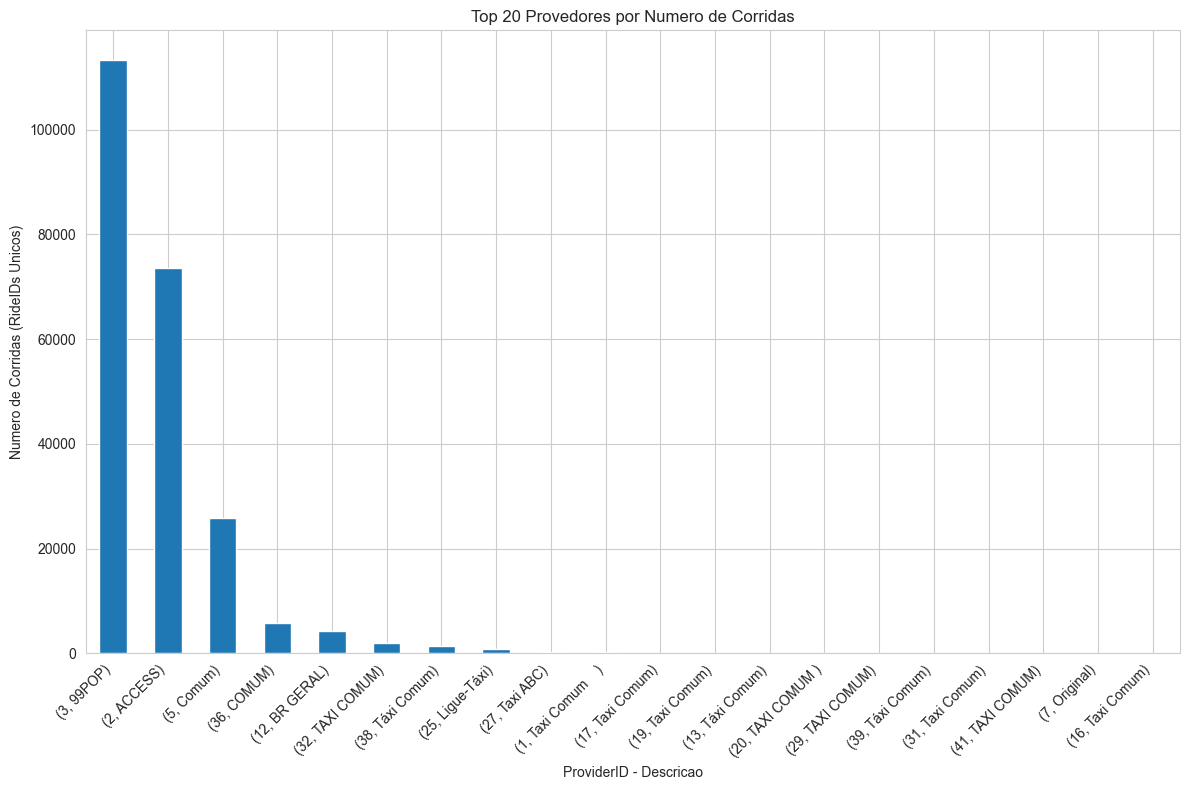


Contagem para Provedores Filtrados (Uber, 99, Cabify, Taxi):
ProviderID_clean  Description   
3                 99POP             113273
32                TAXI COMUM          1930
38                Táxi Comum          1349
25                Ligue-Táxi           830
27                Taxi ABC             288
1                 Taxi Comum           207
17                Taxi Comum           152
19                Taxi Comum           100
13                Táxi Comum            99
20                TAXI COMUM            98
29                TAXI COMUM            81
39                Táxi Comum            74
31                Taxi Comum            50
41                TAXI COMUM            43
16                Taxi Comum            26
18                Taxi comum            20
33                Taxi Comum            17
28                Taxi Comum            16
35                Táxi Comum             7
34                Táxi Comum             6
22                Taxi Comum             6
30

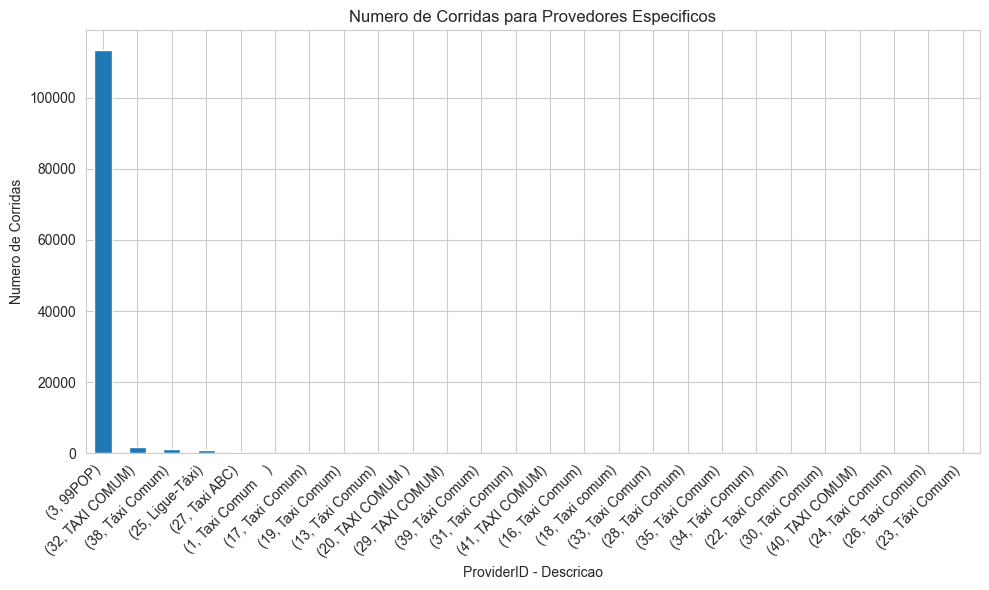

In [15]:
# Bloco 2.1: Analise da Distribuicao de Corridas por ProviderID

if not df_rides.empty and not df_prod.empty:
    print("\n--- Analise de Distribuicao de Corridas por ProviderID ---")

    # Seleciona colunas relevantes de df_rides
    # 'ProviderID' em df_rides e a chave para juntar com df_prod
    if 'ProviderID' not in df_rides.columns:
        print("ERRO: Coluna 'ProviderID' nao encontrada em ride_v2.csv (df_rides). Nao e possivel analisar por provedor.")
    elif 'ProviderID' not in df_prod.columns:
        print("ERRO: Coluna 'ProviderID' nao encontrada em product.csv (df_prod). Nao e possivel analisar por provedor.")
    else:
        # Garante que ProviderID seja do mesmo tipo em ambos para o merge
        # Tenta converter para numerico (int), mas lida com strings que nao sao numericas
        # Se ProviderID for consistentemente string em ambos, pode converter para string
        try:
            # Converte ProviderID em df_rides para numerico (se possivel) ou mantem como string
            if pd.api.types.is_numeric_dtype(df_rides['ProviderID']):
                df_rides['ProviderID_clean'] = df_rides['ProviderID'].astype('Int64') # Usar Int64 para permitir NaNs
            else: # Se ja for string ou misto, tenta converter o que e numero
                df_rides['ProviderID_clean'] = pd.to_numeric(df_rides['ProviderID'], errors='ignore')
                # Se apos to_numeric ainda nao for numerico, converte para string para o merge
                if not pd.api.types.is_numeric_dtype(df_rides['ProviderID_clean']):
                     df_rides['ProviderID_clean'] = df_rides['ProviderID'].astype(str).str.strip()


            # Converte ProviderID em df_prod para o mesmo tipo
            if pd.api.types.is_numeric_dtype(df_prod['ProviderID']):
                df_prod['ProviderID_clean'] = df_prod['ProviderID'].astype('Int64')
            else:
                df_prod['ProviderID_clean'] = pd.to_numeric(df_prod['ProviderID'], errors='ignore')
                if not pd.api.types.is_numeric_dtype(df_prod['ProviderID_clean']):
                     df_prod['ProviderID_clean'] = df_prod['ProviderID'].astype(str).str.strip()

            # Remove duplicatas de ProviderID/Description em df_prod para evitar multiplicacao no merge
            df_prod_unique_providers = df_prod[['ProviderID_clean', 'Description']].drop_duplicates(subset=['ProviderID_clean'])

            # Merge para obter a descricao do provedor
            df_rides_with_provider_desc = pd.merge(
                df_rides[['RideID', 'ProviderID_clean']], # Usa a coluna limpa
                df_prod_unique_providers,
                on='ProviderID_clean',
                how='left' # Left join para manter todas as corridas, mesmo se o provider nao estiver em product.csv
            )

            # Contagem de corridas por ProviderID e Descricao
            # Usamos nunique() em RideID para contar corridas unicas, caso haja duplicatas no merge
            provider_counts = df_rides_with_provider_desc.groupby(['ProviderID_clean', 'Description'])['RideID'].nunique().sort_values(ascending=False)

            print("\nContagem de Corridas (RideID unicos) por ProviderID e Descricao:")
            print(provider_counts)

            # Plotar as contagens (Top N provedores)
            top_n = 20 # Mostrar os 20 principais
            plt.figure(figsize=(12, 8))
            provider_counts.head(top_n).plot(kind='bar')
            plt.title(f'Top {top_n} Provedores por Numero de Corridas')
            plt.xlabel('ProviderID - Descricao')
            plt.ylabel('Numero de Corridas (RideIDs Unicos)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # Filtrar e mostrar apenas Uber, 99, Cabify e Taxi se possivel
            keywords = ['uber', '99', 'cabify', 'taxi', 'táxi'] # Adicione variacoes
            filtered_providers = provider_counts.loc[
                provider_counts.index.get_level_values('Description').str.contains('|'.join(keywords), case=False, na=False)
            ]

            print("\nContagem para Provedores Filtrados (Uber, 99, Cabify, Taxi):")
            if not filtered_providers.empty:
                print(filtered_providers)
                plt.figure(figsize=(10, 6))
                filtered_providers.plot(kind='bar')
                plt.title('Numero de Corridas para Provedores Especificos')
                plt.xlabel('ProviderID - Descricao')
                plt.ylabel('Numero de Corridas')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print("Nenhum provedor encontrado com os keywords especificados.")

        except KeyError as e:
             print(f"ERRO: Chave ausente durante o processamento de ProviderID: {e}")
        except Exception as e:
             print(f"ERRO inesperado durante a analise de ProviderID: {e}")
else:
    print("AVISO: df_rides ou df_prod esta vazio. Pulando analise de ProviderID.")

In [1]:
# -*- coding: utf-8 -*-
# Bloco Unico: Preparacao Completa dos Dados para Modelagem

import pandas as pd
import numpy as np
import time # Para a funcao de feriados (se usar cache com timestamp)
import requests # Para API de feriados
from datetime import datetime
import holidays # Para feriados (alternativa a API)
import warnings

# --- 0. Configuracoes Globais ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
print("--- INICIO DA PREPARACAO DOS DADOS ---")

# --- 1. Caminhos dos Arquivos e Constantes ---
PATH_RIDE_V2 = './data/ride_v2.csv'
PATH_ESTIMATIVE_V3 = './data/rideestimative_v3.csv'
PATH_PRODUCT = './data/product.csv'
# <<< IMPORTANTE: Use o nome do arquivo CSV gerado pelo seu script ORS local >>>
PATH_ORS_RESULTS = './data/ors_local_coords_only_results.csv'
#PATH_ORS_RESULTS = './data/geocoded_ors_results.csv' # Se voce usou o script com geocoding

OUTPUT_FINAL_CSV = './data/dataset_consolidado_para_modelo.csv'

MERGE_KEY_RIDE = "RideID" # Nome da coluna chave nos arquivos
MERGE_KEY_PRODUCT = "ProductID"

# --- 2. Funcoes Auxiliares ---

# Cache para feriados (evita chamadas repetidas a API)
holiday_cache = {}
def get_holiday_info(date_obj):
    year = date_obj.year
    date_str = date_obj.strftime("%Y-%m-%d")
    if year not in holiday_cache:
        print(f"   Buscando feriados para o ano {year} via BrasilAPI...")
        try:
            response = requests.get(f"https://brasilapi.com.br/api/feriados/v1/{year}", timeout=5)
            response.raise_for_status() # Levanta erro para status 4xx/5xx
            holiday_data = response.json()
            holiday_cache[year] = {item['date'] for item in holiday_data} # Armazena apenas as datas
        except requests.exceptions.RequestException as e:
            print(f"   WARN: Falha ao buscar feriados para {year}: {e}. Assumindo nao feriado.")
            holiday_cache[year] = set() # Cache vazio em caso de erro
    return 1 if date_str in holiday_cache[year] else 0

def fix_datetime_str(dt_str):
    if pd.isna(dt_str): return None
    dt_str = str(dt_str).strip()
    if '.' in dt_str: # Lida com microssegundos
        parts = dt_str.split('.', 1)
        if len(parts[1]) > 6: # Limita a 6 digitos de microssegundos
            dt_str = parts[0] + '.' + parts[1][:6]
    return dt_str

# --- 3. Carregamento dos Dados ---
print("\n1. Carregando arquivos CSV...")
try:
    df_rides = pd.read_csv(PATH_RIDE_V2, sep=';', low_memory=False, on_bad_lines='warn', encoding='utf-8')
except UnicodeDecodeError: df_rides = pd.read_csv(PATH_RIDE_V2, sep=';', low_memory=False, on_bad_lines='warn', encoding='latin-1')

try:
    df_estim = pd.read_csv(PATH_ESTIMATIVE_V3, sep=';', low_memory=False, on_bad_lines='warn', encoding='utf-8')
except UnicodeDecodeError: df_estim = pd.read_csv(PATH_ESTIMATIVE_V3, sep=';', low_memory=False, on_bad_lines='warn', encoding='latin-1')

try:
    df_prod = pd.read_csv(PATH_PRODUCT, sep=';', encoding='utf-8')
except UnicodeDecodeError: df_prod = pd.read_csv(PATH_PRODUCT, sep=';', encoding='latin-1')

try:
    df_ors = pd.read_csv(PATH_ORS_RESULTS, sep=';', encoding='utf-8') # Assumindo ; como separador
except FileNotFoundError:
    print(f"ERRO: Arquivo de resultados ORS '{PATH_ORS_RESULTS}' nao encontrado. Execute o script de calculo de rotas primeiro.")
    exit()
except Exception as e:
    print(f"ERRO ao carregar '{PATH_ORS_RESULTS}'. Verifique o separador. Detalhe: {e}")
    exit()

print("   → CSVs carregados.")
print(f"   df_rides: {df_rides.shape}, df_estim: {df_estim.shape}, df_prod: {df_prod.shape}, df_ors: {df_ors.shape}")

# --- 4. Selecao e Renomeacao de Colunas ---
print("\n2. Selecionando e renomeando colunas...")
df_rides = df_rides[[MERGE_KEY_RIDE, 'Create', 'ProviderID']].copy()
df_rides.columns = ['ride_id', 'datetime_str', 'provider_id_ride']

df_estim = df_estim[[MERGE_KEY_RIDE, MERGE_KEY_PRODUCT, 'Price']].copy()
df_estim.columns = ['ride_id', 'product_id', 'price']

df_prod = df_prod[['ProductID', 'ProviderID', 'Description']].copy()
df_prod.columns = ['product_id', 'provider_id_prod', 'product_description']

df_ors = df_ors[['ride_id', 'distance_m', 'duration_s']].copy() # Assumindo estes nomes de coluna

# --- 5. Limpeza Inicial de Tipos e Chaves ---
print("\n3. Limpando tipos de dados para merge...")
# Garante que 'ride_id' seja int em todos os DFs
for df_ in [df_rides, df_estim, df_ors]:
    if 'ride_id' in df_.columns:
        df_['ride_id'] = pd.to_numeric(df_['ride_id'], errors='coerce').fillna(-1).astype(int)
        df_.drop(df_[df_['ride_id'] == -1].index, inplace=True) # Remove ride_ids invalidos

# Garante que 'product_id' seja string para merge (pode ser misto)
df_estim['product_id'] = df_estim['product_id'].astype(str).str.strip()
df_prod['product_id'] = df_prod['product_id'].astype(str).str.strip()

# --- 6. Merging dos DataFrames ---
print("\n4. Realizando merges...")
# Base: df_estim (cada linha e uma estimativa com um preco)
df_merged = df_estim.copy()
print(f"   Tamanho inicial (estimativas): {len(df_merged)}")

# Merge com df_rides (para obter datetime e provider_id da corrida)
df_merged = pd.merge(df_merged, df_rides, on='ride_id', how='inner')
print(f"   Apos merge com corridas (rides): {len(df_merged)}")

# Merge com df_ors (para obter distancia e duracao)
# Remove duplicatas de ride_id em df_ors para evitar multiplicacao de linhas
df_ors_unique = df_ors.drop_duplicates(subset=['ride_id'], keep='first')
df_merged = pd.merge(df_merged, df_ors_unique, on='ride_id', how='inner')
print(f"   Apos merge com resultados ORS: {len(df_merged)}")

# Merge com df_prod (para obter descricao do produto e provider_id do produto)
df_merged = pd.merge(df_merged, df_prod, on='product_id', how='left')
print(f"   Apos merge com produtos: {len(df_merged)}")

# --- 7. Limpeza de Dados Pos-Merge ---
print("\n5. Limpeza de dados pos-merge...")
initial_rows = len(df_merged)

# 7.1 Preco
df_merged['price'] = pd.to_numeric(df_merged['price'], errors='coerce')
df_merged.dropna(subset=['price'], inplace=True)
df_merged = df_merged[df_merged['price'] > 0.1] # Remove precos muito baixos ou zero
print(f"   Linhas apos limpar 'price' (NaN, <=0.1): {len(df_merged)}")

# 7.2 Distancia e Duracao
df_merged['distance_m'] = pd.to_numeric(df_merged['distance_m'], errors='coerce')
df_merged['duration_s'] = pd.to_numeric(df_merged['duration_s'], errors='coerce')
df_merged.dropna(subset=['distance_m', 'duration_s'], inplace=True) # Requer que ORS tenha dado resultado
# Considera corridas com distancia/duracao zero como validas (pontos muito proximos)
# Mas remove se um e zero e o outro nao (inconsistencia)
df_merged = df_merged[~((df_merged['distance_m'] == 0) & (df_merged['duration_s'] > 0))]
df_merged = df_merged[~((df_merged['duration_s'] == 0) & (df_merged['distance_m'] > 0))]
print(f"   Linhas apos limpar 'distance_m'/'duration_s': {len(df_merged)}")

# 7.3 Data/Hora
df_merged['datetime_str'] = df_merged['datetime_str'].apply(fix_datetime_str)
df_merged['datetime'] = pd.to_datetime(df_merged['datetime_str'], errors='coerce')
df_merged.dropna(subset=['datetime'], inplace=True) # Remove se datetime for invalido
print(f"   Linhas apos limpar 'datetime': {len(df_merged)}")

print(f"   → Total de linhas removidas na limpeza: {initial_rows - len(df_merged)}")
print(f"   Dataset final com {len(df_merged)} linhas e {df_merged['ride_id'].nunique()} RideIDs unicos.")

# --- 8. Feature Engineering ---
print("\n6. Criando features...")
df_fe = df_merged.copy()

df_fe['year']    = df_fe['datetime'].dt.year
df_fe['month']   = df_fe['datetime'].dt.month
df_fe['day']     = df_fe['datetime'].dt.day
df_fe['weekday']= df_fe['datetime'].dt.weekday + 1 # Seg=1, Dom=7
df_fe['hour']    = df_fe['datetime'].dt.hour
df_fe['minute']  = df_fe['datetime'].dt.minute
df_fe['hour_min']= df_fe['hour'] + df_fe['minute'] / 60.0

# Features ciclicas
df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour_min'] / 24)
df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour_min'] / 24)
df_fe['weekday_sin'] = np.sin(2 * np.pi * df_fe['weekday'] / 7)
df_fe['weekday_cos'] = np.cos(2 * np.pi * df_fe['weekday'] / 7)

# Feature de feriado
print("   Calculando feriados...")
df_fe['is_holiday'] = df_fe['datetime'].dt.date.apply(get_holiday_info)
print(f"   → Feriados calculados. Total: {df_fe['is_holiday'].sum()}")

# Categorizacao de Provedor
print("   Categorizando provedores...")
def categorize_provider(row):
    desc = str(row.get('product_description', '')).lower()
    prod_id_str = str(row.get('product_id', '')).lower() # product_id da estimativa
    # ProviderID da tabela 'rides' e o mais confiavel para o provedor GERAL da corrida
    prov_id_ride = row.get('provider_id_ride') # Este e o ProviderID da tabela ride_v2

    # Mapeamento conhecido de ProviderID para grupos
    # Ajuste estes IDs conforme a sua analise do product.csv e ride_v2.csv
    if prov_id_ride == 2: return 'Uber'  # Assumindo que 2 e sempre Uber
    if prov_id_ride == 3: return '99'    # Assumindo que 3 e sempre 99
    if prov_id_ride == 4: return 'Cabify'# Assumindo que 4 e sempre Cabify
    
    # Se nao for pelos IDs principais, tenta por descricao/product_id
    if 'uber' in desc or 'uber' in prod_id_str: return 'Uber'
    if '99' in desc or '99' in prod_id_str: return '99'
    if 'cabify' in desc or 'cabify' in prod_id_str: return 'Cabify'
    if 'taxi' in desc or 'táxi' in desc or 'taxid' in desc or \
       'taxi' in prod_id_str or 'táxi' in prod_id_str or 'taxid' in prod_id_str:
        return 'Taxi'
    return 'Outros'

df_fe['provider_group'] = df_fe.apply(categorize_provider, axis=1)
print(df_fe['provider_group'].value_counts())

# One-Hot Encoding para 'provider_group'
print("   Aplicando One-Hot Encoding para 'provider_group'...")
df_final = pd.get_dummies(df_fe, columns=['provider_group'], prefix='prov', drop_first=False)
# drop_first=False cria uma coluna para cada categoria.

print("\nFeatures finais criadas. Amostra:")
print(df_final.head())

# --- 9. Selecao Final de Colunas e Salvamento ---
print("\n7. Selecionando colunas finais e salvando CSV...")

# Lista de features para o modelo (ajuste conforme necessario)
# Incluindo as colunas one-hot encoded de provedor
model_features = [
    'hour_min', 'hour_sin', 'hour_cos',
    'weekday', 'weekday_sin', 'weekday_cos', # Mantem weekday original e ciclicas
    'day', 'month', 'year',
    'is_holiday',
    'distance_m', 'duration_s',
    # Colunas de provedor apos one-hot encoding (verifique os nomes exatos gerados)
    'prov_99', 'prov_Cabify', 'prov_Outros', 'prov_Taxi', 'prov_Uber' # Ajuste se os nomes forem diferentes
]
# Adiciona o target
target_col = 'price'

# Garante que todas as features do modelo existam no DataFrame
final_cols_to_keep = [target_col] + [feat for feat in model_features if feat in df_final.columns]
# Adiciona identificadores se quiser no CSV final
final_cols_to_keep = ['ride_id', 'product_id'] + final_cols_to_keep

# Remove colunas que nao estao na lista (para limpar antes de salvar)
# Mas verifica se elas existem primeiro
cols_existentes_no_df = df_final.columns.tolist()
df_to_save = df_final[[col for col in final_cols_to_keep if col in cols_existentes_no_df]].copy()


print("\nDataFrame final a ser salvo:")
print(df_to_save.head())
print(f"Shape: {df_to_save.shape}")
df_to_save.info()

try:
    df_to_save.to_csv(OUTPUT_FINAL_CSV, index=False, sep=';', encoding='utf-8')
    print(f"\n✅ DataFrame consolidado e limpo salvo em: {OUTPUT_FINAL_CSV}")
except Exception as e:
    print(f"\n!!! ERRO ao salvar o CSV final: {e}")

print("\n--- FIM DA PREPARACAO ---")

--- INICIO DA PREPARACAO DOS DADOS ---

1. Carregando arquivos CSV...
   → CSVs carregados.
   df_rides: (500000, 15), df_estim: (2000000, 9), df_prod: (237, 4), df_ors: (499723, 4)

2. Selecionando e renomeando colunas...

3. Limpando tipos de dados para merge...

4. Realizando merges...
   Tamanho inicial (estimativas): 2000000
   Apos merge com corridas (rides): 2000000
   Apos merge com resultados ORS: 1999989
   Apos merge com produtos: 1999989

5. Limpeza de dados pos-merge...
   Linhas apos limpar 'price' (NaN, <=0.1): 1999986
   Linhas apos limpar 'distance_m'/'duration_s': 1999466
   Linhas apos limpar 'datetime': 1999466
   → Total de linhas removidas na limpeza: 523
   Dataset final com 1999466 linhas e 239192 RideIDs unicos.

6. Criando features...
   Calculando feriados...
   Buscando feriados para o ano 2021 via BrasilAPI...
   Buscando feriados para o ano 2022 via BrasilAPI...
   → Feriados calculados. Total: 6713
   Categorizando provedores...
provider_group
Outros    7

In [20]:
# Bloco 3: Definicao de Features (X) e Target (y), e divisao Treino/Teste

if not df_model.empty:
    print("\n3. Definindo Features e Target...")

    # Lista de todas as colunas candidatas a features (incluindo as one-hot encoded)
    # A coluna 'price' e o nosso target
    # 'ride_id', 'product_id', 'datetime' sao identificadores/informativos, nao features diretas
    
    # Identifica as colunas de provedor (geradas pelo get_dummies)
    provider_cols = [col for col in df_model.columns if col.startswith('prov_')]
    print(f"   Colunas de provedor detectadas (one-hot): {provider_cols}")

    features_base = [
        'hour_min', 'hour_sin', 'hour_cos',
        'weekday',  # Pode testar com e sem a original se ja tem as ciclicas
        'weekday_sin', 'weekday_cos',
        'day', 'month', 'year',
        'is_holiday',
        'distance_m', 'duration_s'
    ]
    
    # Adiciona as colunas de provedor (one-hot encoded) a lista de features
    features_X = features_base + provider_cols
    target_y = 'price'

    # Verifica se todas as features existem
    missing_X_cols = [f for f in features_X if f not in df_model.columns]
    if missing_X_cols:
        print(f"ERRO: As seguintes features nao foram encontradas no DataFrame: {missing_X_cols}")
        # Decide se quer parar ou continuar sem elas
        features_X = [f for f in features_X if f in df_model.columns]
        print(f"   Usando features encontradas: {features_X}")

    if target_y not in df_model.columns:
        print(f"ERRO: Coluna target '{target_y}' nao encontrada!")
        # Parar execucao
        X, y = pd.DataFrame(), pd.Series() # Cria DFs vazios
    else:
        X = df_model[features_X].copy()
        y = df_model[target_y].copy()

        # Verifica se ha NaNs nas features ou target selecionados
        if X.isnull().any().any():
            print("WARN: Encontrados NaNs nas features X. Preenchendo com mediana...")
            for col in X.columns[X.isnull().any()]:
                X[col].fillna(X[col].median(), inplace=True) # Imputacao simples com mediana
        if y.isnull().any():
            print("WARN: Encontrados NaNs no target y. Removendo essas linhas...")
            y.dropna(inplace=True)
            X = X.loc[y.index] # Alinha X com y

        print(f"\n   Features (X) selecionadas para o modelo ({len(features_X)}): {features_X}")
        print(f"   Target (y): {target_y}")
        print(f"   Shape de X: {X.shape}, Shape de y: {y.shape}")

        if X.empty or y.empty:
             print("ERRO: X ou y esta vazio apos processamento. Verifique os passos anteriores.")
        else:
            # --- Divisao Treino/Teste ---
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"\n   Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")
else:
    print("ERRO: df_model esta vazio. Pulando definicao de features e treino.")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series() # Cria vazios


3. Definindo Features e Target...
   Colunas de provedor detectadas (one-hot): ['prov_99', 'prov_Outros', 'prov_Taxi', 'prov_Uber']

   Features (X) selecionadas para o modelo (16): ['hour_min', 'hour_sin', 'hour_cos', 'weekday', 'weekday_sin', 'weekday_cos', 'day', 'month', 'year', 'is_holiday', 'distance_m', 'duration_s', 'prov_99', 'prov_Outros', 'prov_Taxi', 'prov_Uber']
   Target (y): price
   Shape de X: (1999466, 16), Shape de y: (1999466,)

   Dados divididos: 1599572 para treino, 399894 para teste.


AVISO: Nenhum DataFrame (df_final_to_save ou df_cleaned) encontrado na memoria.
Tentando carregar de './data/dataset_consolidado_para_modelo.csv'...
Carregado './data/dataset_consolidado_para_modelo.csv' com 1999466 linhas.

10.1 Preparando dados para modelagem...
   Features para o modelo (16): ['hour_min', 'hour_sin', 'hour_cos', 'weekday', 'weekday_sin', 'weekday_cos', 'day', 'month', 'year', 'is_holiday', 'distance_m', 'duration_s', 'prov_99', 'prov_Outros', 'prov_Taxi', 'prov_Uber']
   Target: price
   Split treino/teste: 1599572 treino, 399894 teste.

--- Treinando Linear Regression ---
   Tempo de treino: 0.46s
   RMSE: 40.3101
   MAE:  13.8746
   R²:   0.8623

--- Treinando Random Forest ---
   Tempo de treino: 98.30s
   RMSE: 35.0218
   MAE:  11.4929
   R²:   0.8961

--- Treinando Gradient Boosting ---
   Tempo de treino: 324.01s
   RMSE: 36.2455
   MAE:  11.3397
   R²:   0.8887

--- Treinando XGBoost ---
   Tempo de treino: 1.93s
   RMSE: 73.9507
   MAE:  12.8348
   R²:   0.5

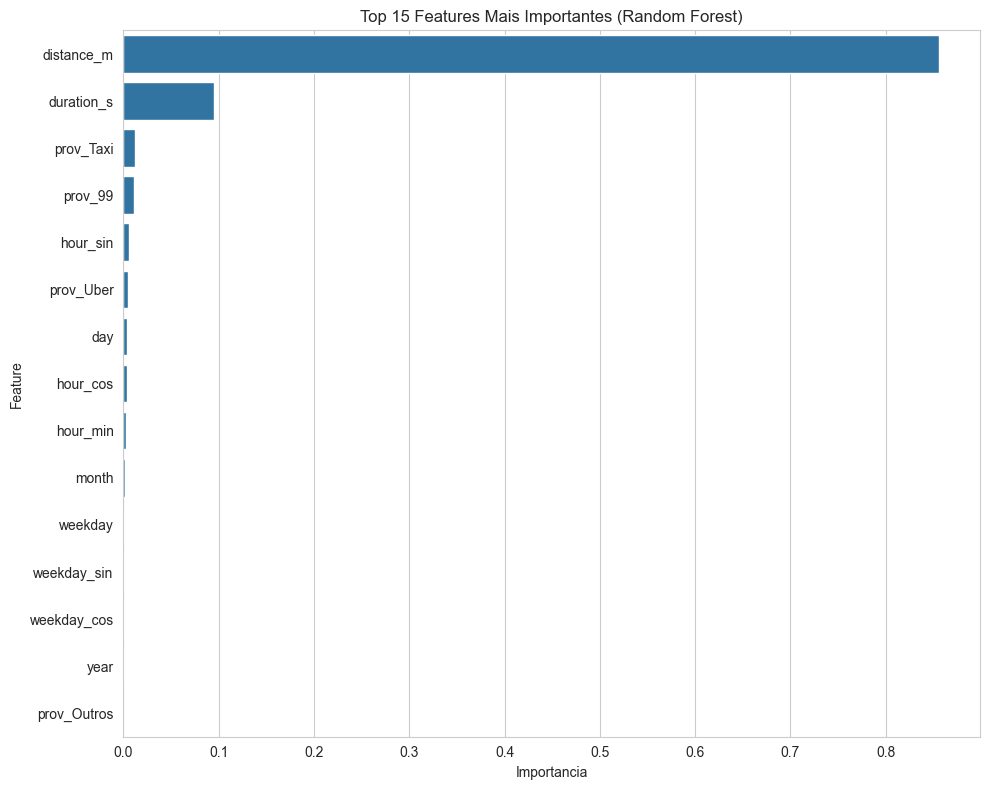


--- Analise de Residuos para o Melhor Modelo Geral (Random Forest) ---


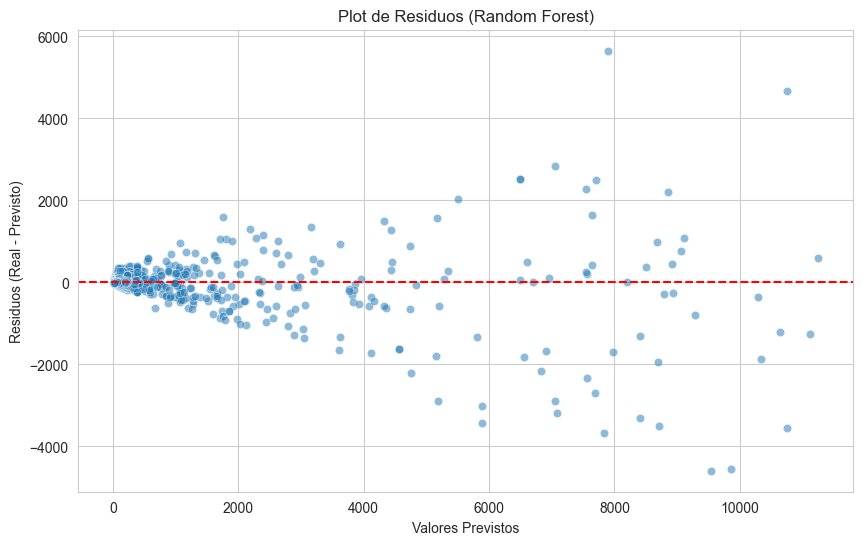

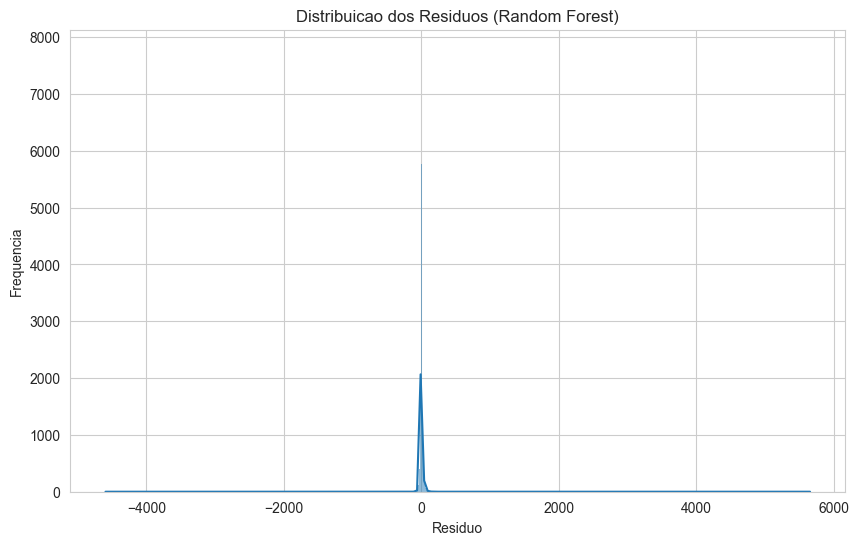


--- Fim do Notebook de Modelagem ---


In [21]:
# Bloco 10: Treinamento, Avaliacao e Importancia das Features

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Inicializa df_modelar como um DataFrame vazio
df_modelar = pd.DataFrame()

# Tenta carregar a partir das variaveis existentes no notebook
if 'df_final_to_save' in locals() and not df_final_to_save.empty:
    df_modelar = df_final_to_save.copy()
    print(f"Iniciando modelagem com df_final_to_save ({len(df_modelar)} linhas).")
elif 'df_cleaned' in locals() and not df_cleaned.empty:
    print("AVISO: Usando 'df_cleaned'. Certifique-se que ele contem as colunas one-hot encoded de provider.")
    df_modelar = df_cleaned.copy()
    if 'provider_group' in df_modelar.columns: # Garante one-hot se estiver usando df_cleaned diretamente
        print("   Aplicando One-Hot Encoding em 'provider_group' em df_cleaned...")
        df_modelar = pd.get_dummies(df_modelar, columns=['provider_group'], prefix='prov', drop_first=False)
    print(f"Iniciando modelagem com df_cleaned ({len(df_modelar)} linhas).")
else:
    # Se nenhum DataFrame estiver disponivel na memoria, tenta carregar do CSV salvo no Bloco 9
    print("AVISO: Nenhum DataFrame (df_final_to_save ou df_cleaned) encontrado na memoria.")
    print("Tentando carregar de './data/dataset_consolidado_para_modelo.csv'...")
    try:
        # <<< CERTIFIQUE-SE QUE O CAMINHO E NOME DO ARQUIVO ESTAO CORRETOS >>>
        df_modelar = pd.read_csv('./data/dataset_consolidado_para_modelo.csv', sep=';')
        print(f"Carregado './data/dataset_consolidado_para_modelo.csv' com {len(df_modelar)} linhas.")
    except FileNotFoundError:
        print("ERRO: Arquivo './data/dataset_consolidado_para_modelo.csv' nao encontrado. Nao e possivel treinar modelos.")
    except Exception as e:
        print(f"ERRO ao carregar './data/dataset_consolidado_para_modelo.csv': {e}")


if not df_modelar.empty:
    # --- 10.1 Preparacao Final para Modelagem ---
    print("\n10.1 Preparando dados para modelagem...")

    # Define a lista de features (DEVE CORRESPONDER AO QUE FOI SALVO NO CSV/MODELO)
    # Se voce salvou 'ride_id', 'product_id', 'datetime' no CSV para referencia,
    # mas eles NAO sao features para o modelo, exclua-os aqui.
    features_para_modelo = [
        'hour_min', 'hour_sin', 'hour_cos',
        'weekday',  # Usaremos a original, ja que temos sin/cos. Pode testar so com sin/cos.
        'weekday_sin', 'weekday_cos',
        'day', 'month', 'year',
        'is_holiday',
        'distance_m', 'duration_s',
        # Colunas de provedor (verifique os nomes exatos gerados pelo get_dummies no bloco anterior)
        # Ex: 'prov_99', 'prov_Cabify', 'prov_Outros', 'prov_Taxi', 'prov_Uber'
        # Adicione dinamicamente as colunas 'prov_'
    ]
    # Encontra colunas de provedor que foram criadas
    provider_cols_one_hot = [col for col in df_modelar.columns if col.startswith('prov_')]
    features_para_modelo.extend(provider_cols_one_hot)

    # Garante que todas as features listadas realmente existem no DataFrame
    features_existentes = [f for f in features_para_modelo if f in df_modelar.columns]
    if len(features_existentes) != len(features_para_modelo):
        ausentes = set(features_para_modelo) - set(features_existentes)
        print(f"AVISO: As seguintes features especificadas nao foram encontradas e serao ignoradas: {ausentes}")
    features_para_modelo = features_existentes # Usa apenas as que existem

    target = 'price'

    print(f"   Features para o modelo ({len(features_para_modelo)}): {features_para_modelo}")
    print(f"   Target: {target}")

    # Verifica se ha NaNs nas features ou target antes de treinar
    if df_modelar[features_para_modelo].isnull().any().any():
        print("   AVISO: Encontrados NaNs nas features selecionadas. Removendo linhas com NaNs...")
        df_modelar.dropna(subset=features_para_modelo, inplace=True)
    if df_modelar[target].isnull().any():
        print("   AVISO: Encontrados NaNs na coluna target. Removendo linhas com NaNs...")
        df_modelar.dropna(subset=[target], inplace=True)

    if len(df_modelar) < 100: # Numero minimo de amostras
        print("ERRO: Poucos dados restantes apos limpeza para treinar modelos. Verifique os passos anteriores.")
    else:
        X = df_modelar[features_para_modelo]
        y = df_modelar[target]

        # Split Treino/Teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"   Split treino/teste: {len(X_train)} treino, {len(X_test)} teste.")

        # --- 10.2 Treinamento e Avaliacao dos Modelos ---
        models = {
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=5),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=5),
            "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1,
                                        learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8)
        }

        results = {}
        feature_importances = {}

        for name, model in models.items():
            print(f"\n--- Treinando {name} ---")
            start_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_time
            print(f"   Tempo de treino: {train_time:.2f}s")

            predictions = model.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

            results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Train Time (s)': train_time}
            print(f"   RMSE: {rmse:.4f}")
            print(f"   MAE:  {mae:.4f}")
            print(f"   R²:   {r2:.4f}")

            # Captura importancia das features para modelos baseados em arvores
            if hasattr(model, 'feature_importances_'):
                importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
                feature_importances[name] = importances

        # --- 10.3 Comparacao das Metricas ---
        print("\n\n--- Comparacao de Metricas dos Modelos ---")
        results_df = pd.DataFrame(results).T.sort_values(by='RMSE') # Ordena por RMSE (menor e melhor)
        print(results_df)

        # --- 10.4 Visualizacao da Importancia das Features (para o melhor modelo de arvore) ---
        best_tree_model_name = None
        best_r2_tree = -float('inf')

        # Encontra o melhor modelo de arvore (Random Forest, Gradient Boosting, XGBoost) pelo R2
        tree_models_to_check = ["Random Forest", "Gradient Boosting", "XGBoost"]
        for name in tree_models_to_check:
            if name in results and results[name]['R2'] > best_r2_tree:
                best_r2_tree = results[name]['R2']
                best_tree_model_name = name

        if best_tree_model_name and best_tree_model_name in feature_importances:
            print(f"\n--- Importancia das Features para o Melhor Modelo de Arvore ({best_tree_model_name}) ---")
            print(feature_importances[best_tree_model_name].head(15)) # Mostra top 15

            plt.figure(figsize=(10, 8))
            sns.barplot(x=feature_importances[best_tree_model_name].head(15), y=feature_importances[best_tree_model_name].head(15).index)
            plt.title(f'Top 15 Features Mais Importantes ({best_tree_model_name})')
            plt.xlabel('Importancia')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNao foi possivel determinar o melhor modelo de arvore ou suas importancias de features.")

        # --- 10.5 Plot de Residuos (para o melhor modelo geral) ---
        best_overall_model_name = results_df.index[0] # Modelo com menor RMSE
        print(f"\n--- Analise de Residuos para o Melhor Modelo Geral ({best_overall_model_name}) ---")

        best_model_instance = None
        for name, model_inst in models.items():
            if name == best_overall_model_name:
                best_model_instance = model_inst
                break
        
        if best_model_instance:
            best_predictions = best_model_instance.predict(X_test)
            residuals = y_test - best_predictions

            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=best_predictions, y=residuals, alpha=0.5)
            plt.axhline(0, color='red', linestyle='--')
            plt.title(f'Plot de Residuos ({best_overall_model_name})')
            plt.xlabel('Valores Previstos')
            plt.ylabel('Residuos (Real - Previsto)')
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.histplot(residuals, kde=True)
            plt.title(f'Distribuicao dos Residuos ({best_overall_model_name})')
            plt.xlabel('Residuo')
            plt.ylabel('Frequencia')
            plt.show()
        else:
            print("Nao foi possivel encontrar a instancia do melhor modelo para plotar residuos.")
else:
    print("ERRO: DataFrame df_modelar esta vazio. Modelagem abortada.")

print("\n--- Fim do Notebook de Modelagem ---")